In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division, print_function
import os
from collections import namedtuple
import numpy as np
import pandas as pd
import xarray as xr
import pyunfold
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

import comptools as comp

sns.set_context(context='paper', font_scale=1.5)
color_dict = comp.color_dict

%matplotlib inline

In [3]:
config = 'IC86.2012'
num_groups = 2

comp_list = comp.get_comp_list(num_groups=num_groups)
energybins = comp.get_energybins(config)
num_ebins = len(energybins.log_energy_midpoints)

unfolding_dir  = os.path.join(comp.paths.comp_data_dir,
                              config,
                              'unfolding')

In [4]:
feature_list, feature_labels = comp.get_training_features()

Load trained models

In [5]:
energy_pipeline = comp.load_trained_model('linearregression_energy_{}'.format(config))
pipeline_str = 'xgboost_comp_{}_{}-groups'.format(config, num_groups)
comp_pipeline = comp.load_trained_model(pipeline_str)

In [6]:
# Load DataFrame with saved prior distributions
df_file = os.path.join(unfolding_dir,
                       'unfolding-df_{}-groups.hdf'.format(num_groups))
df_priors = pd.read_hdf(df_file)
df_priors.head()

,counts,counts_err,efficiencies,efficiencies_err,broken_power_law_flux,broken_power_law_prior,simple_power_law_flux,simple_power_law_prior,H3a_flux,H3a_prior,H4a_flux,H4a_prior
log_energy_bin_idx,,,,,,,,,,,,
0,1071404.0,1035.086470,0.007119,0.000084,1.416780e-12,0.231674,1.416780e-12,0.231486,7.187420e-13,0.302586,7.333020e-13,0.306455
1,743932.0,862.514927,0.006400,0.000078,1.416780e-12,0.231674,1.416780e-12,0.231486,4.082709e-13,0.171880,4.023280e-13,0.168137
2,851277.0,922.646736,0.007928,0.000075,7.608561e-13,0.124416,7.608561e-13,0.124315,3.743101e-13,0.157582,3.821589e-13,0.159708
3,702982.0,838.440219,0.007473,0.000068,7.608561e-13,0.124416,7.608561e-13,0.124315,2.232925e-13,0.094005,2.198728e-13,0.091887
4,579872.0,761.493270,0.008373,0.000068,4.086039e-13,0.066816,4.086039e-13,0.066761,1.925426e-13,0.081059,1.967681e-13,0.082231


In [7]:
# Load fitted efficiencies and calculate effective areas
eff_path = os.path.join(comp.paths.comp_data_dir, config, 'efficiencies',
                        'efficiency_fit_num_groups_{}.hdf'.format(num_groups))
df_eff = pd.read_hdf(eff_path)
df_eff.head()

,eff_median_light,eff_err_low_light,eff_err_high_light,eff_median_heavy,eff_err_low_heavy,eff_err_high_heavy,eff_median_total,eff_err_low_total,eff_err_high_total
0,0.007119,0.000084,0.000077,0.006400,0.000078,0.000083,0.006739,0.000057,0.000053
1,0.007928,0.000075,0.000062,0.007473,0.000068,0.000072,0.007685,0.000044,0.000047
2,0.008373,0.000068,0.000063,0.008005,0.000064,0.000069,0.008194,0.000043,0.000046
3,0.008609,0.000070,0.000066,0.008268,0.000065,0.000067,0.008458,0.000046,0.000046
4,0.008735,0.000072,0.000068,0.008421,0.000063,0.000067,0.008606,0.000048,0.000045


In [8]:
# Get simulation thrown areas for each energy bin
thrown_radii = comp.simfunctions.get_sim_thrown_radius(energybins.log_energy_midpoints)
thrown_area = np.pi * thrown_radii.max()**2
thrown_area

9079202.768874502

In [9]:
efficiencies, efficiencies_err = comp.get_detector_efficiencies(config=config,
                                                                num_groups=num_groups,
                                                                sigmoid='flat',
                                                                pyunfold_format=True)

Load and process data

In [10]:
print('Loading data into memory...')
df_data = comp.load_data(config=config,
                         processed=True,
                         columns=feature_list,
                         n_jobs=15,
                         verbose=True)

Loading data into memory...
[########################################] | 100% Completed |  1min 36.0s


In [11]:
X_data = df_data[feature_list].values

In [12]:
print('Running composition classifications...')
df_data['pred_comp_target'] = comp_pipeline.predict(X_data)
print('Running energy regressions...')
df_data['reco_log_energy'] = energy_pipeline.predict(X_data)

Running composition classifications...


/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Running energy regressions...


In [13]:
counts_observed = {}
counts_observed_err = {}

for comp_idx, composition in enumerate(comp_list):
    print(composition)
    # Filter out events that don't pass composition & energy mask
    pred_comp_mask = df_data['pred_comp_target'] == comp_idx
    mask = pred_comp_mask
    
    energies = df_data.loc[mask, 'reco_log_energy'].values
    comp_counts, _ = np.histogram(energies, bins=energybins.log_energy_bins)
    counts_observed[composition] = comp_counts
    counts_observed_err[composition] = np.sqrt(comp_counts)

counts_observed_err['total'] = np.sqrt(np.sum(counts_observed_err[composition]**2 for composition in comp_list))
# Calculate total counts
counts_observed['total'] = np.sum(counts_observed[composition] for composition in comp_list)

# Format observed counts, detection efficiencies, and priors for PyUnfold use
counts_pyunfold = np.empty(num_groups * len(energybins.energy_midpoints))
counts_err_pyunfold = np.empty(num_groups * len(energybins.energy_midpoints))
for idx, composition in enumerate(comp_list):
    counts_pyunfold[idx::num_groups] = counts_observed[composition]
    counts_err_pyunfold[idx::num_groups] = counts_observed_err[composition]

light
heavy


In [14]:
counts_observed

{'heavy': array([868221, 717761, 508140, 353515, 236173, 146384, 100793,  55633,
         37563,  26061,  14499,   9614,   6440,   4208,   2937,   1956,
          1287,    777,    581]),
 'light': array([1204413,  869129,  625889,  425480,  279731,  186722,  108435,
          73029,   40325,   20827,   14283,    8073,    4768,    2860,
           1688,     939,     533,     371,     219]),
 'total': array([2072634, 1586890, 1134029,  778995,  515904,  333106,  209228,
         128662,   77888,   46888,   28782,   17687,   11208,    7068,
           4625,    2895,    1820,    1148,     800])}

In [15]:
# # Effective area
# eff_area, eff_area_err = {}, {}
# for composition in comp_list + ['total']:
#     eff_area[composition] = df_eff['eff_median_{}'.format(composition)].values * thrown_area
#     eff_area_err[composition] = df_eff['eff_err_low_{}'.format(composition)].values * thrown_area

# Solid angle
theta_max = 40 if config == 'IC79.2010' else 65
solid_angle = np.pi*np.sin(np.deg2rad(theta_max))**2

# Livetime
livetime, livetime_err = comp.get_detector_livetime(config=config)

In [16]:
def counts_to_flux(counts, counts_err=None, composition=None):
    return comp.get_flux(counts, counts_err,
                         energybins=energybins.energy_bins,
                         eff_area=thrown_area, 
                         livetime=livetime,
                         livetime_err=livetime_err,
                         solid_angle=solid_angle,
                         scalingindex=2.7)

In [17]:
comp_list + ['total']

['light', 'heavy', 'total']

In [18]:
UnfoldedFlux = namedtuple('UnfoldedFlux', ['flux', 'flux_sys_err', 'flux_stat_err'])

In [19]:
def get_unfolded_fluxes(df_file, return_sys_err=False, return_stat_err=False):
    print('df_file = {}'.format(df_file))
    # Load simulation and train composition classifier
    df_sim_train, df_sim_test = comp.load_sim(df_file=df_file,
                                              config=config,
                                              energy_reco=False,
                                              log_energy_min=None,
                                              log_energy_max=None,
                                              test_size=0.5,
                                              n_jobs=10,
                                              verbose=True)
    
    print('Running energy reconstruction...')
    for df in [df_sim_train, df_sim_test]:
        X = df_sim_train[feature_list].values
        # Energy reconstruction
        df['reco_log_energy'] = energy_pipeline.predict(df[feature_list].values)
        df['reco_energy'] = 10**df['reco_log_energy']
        
    print('Running composition classifications...')
    pred_target = comp_pipeline.predict(df_sim_test[feature_list].values)
    
    print('Making response matrix...')
    log_reco_energy_sim_test = df_sim_test['reco_log_energy']
    log_true_energy_sim_test = df_sim_test['MC_log_energy']
    true_target = df_sim_test['comp_target_{}'.format(num_groups)].values

    response, response_err = comp.response_matrix(true_energy=log_true_energy_sim_test,
                                                  reco_energy=log_reco_energy_sim_test,
                                                  true_target=true_target,
                                                  pred_target=pred_target,
                                                  efficiencies=efficiencies,
                                                  efficiencies_err=efficiencies_err,
                                                  energy_bins=energybins.log_energy_bins)
    
#     fig, ax = plt.subplots()
#     im = ax.imshow(response, origin='lower', cmap='viridis')
#     ax.plot([0, response.shape[0] - 1], [0, response.shape[1] - 1], marker='None', ls=':', color='white')
#     comp.plotting.colorbar(im, label='Normalized response matrix')

#     ax.set_xlabel('True bins')
#     ax.set_ylabel('Reconstructed bins')

#     plt.show()
    
    # Run unfolding for each of the priors
    prior_name = 'H4a'
    prior = None if prior_name == 'uniform' else df_priors['{}_prior'.format(prior_name)]
    # priors = 'Jeffreys' if prior_name == 'Jeffreys' else df['{}_prior'.format(prior_name)]
    unfolded_result = pyunfold.iterative_unfold(data=counts_pyunfold,
                                                data_err=counts_err_pyunfold,
                                                response=response,
                                                response_err=response_err,
                                                efficiencies=efficiencies,
                                                efficiencies_err=efficiencies_err,
                                                ts='ks',
                                                ts_stopping=0.005,
                                                prior=prior,
                                                return_iterations=True)
    
    counts, counts_sys_err, counts_stat_err = comp.unfolded_counts_dist(unfolded_result,
                                                                        num_groups=num_groups)
    unfolded_fluxes = {}
    unfolded_sys_err = {}
    unfolded_stat_err = {}
    for composition in comp_list + ['total']:

        flux, flux_sys_err = counts_to_flux(counts=counts[composition],
                                            counts_err=counts_sys_err[composition],
                                            composition=composition)
        flux, flux_stat_err = counts_to_flux(counts=counts[composition],
                                             counts_err=counts_stat_err[composition],
                                             composition=composition)
        
        unfolded_fluxes[composition] = flux
        unfolded_sys_err[composition] = flux_sys_err
        unfolded_stat_err[composition] = flux_stat_err
    
    output = [unfolded_fluxes]
    if return_sys_err:
        output.append(unfolded_sys_err)
    if return_stat_err:
        output.append(unfolded_stat_err)
    
    if len(output) == 1:
        output = output[0]

    return output

Set up mapping between dataset name and file locations

In [20]:
sim_files = {'nominal': '/data/user/jbourbeau/composition/IC86.2012/sim/processed_hdf/nominal/*.hdf',
             'snow_lambda_up': '/data/user/jbourbeau/composition/IC86.2012/sim/processed_hdf/snow_lambda_2.45/*.hdf',
             'snow_lambda_down': '/data/user/jbourbeau/composition/IC86.2012/sim/processed_hdf/snow_lambda_2.05/*.hdf',
             'vem_cal_down': '/data/user/jbourbeau/composition/IC86.2012/sim/sim_dataframe_vem_cal_down.hdf',
             'vem_cal_up': '/data/user/jbourbeau/composition/IC86.2012/sim/sim_dataframe_vem_cal_up.hdf',
             'dom_eff_up': '/data/user/jbourbeau/composition/IC86.2012/sim/processed_hdf/dom_eff_1.08504/*.hdf',
             'dom_eff_down': '/data/user/jbourbeau/composition/IC86.2012/sim/processed_hdf/dom_eff_0.86625/*.hdf',
            }

unfolded_results = {}
for sys_name, f in sim_files.items():
    unfolded_results[sys_name] = get_unfolded_fluxes(f)

df_file = /data/user/jbourbeau/composition/IC86.2012/sim/processed_hdf/snow_lambda_2.45/*.hdf
[########################################] | 100% Completed |  4.6s
Running energy reconstruction...
Running composition classifications...


/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Making response matrix...


/home/jbourbeau/cr-composition/comptools/data_functions.py:25: RuntimeWarning: invalid value encountered in true_divide
  ratio_err = np.abs(ratio) * np.sqrt((num_err / num)**2 + (den_err / den)**2)


df_file = /data/user/jbourbeau/composition/IC86.2012/sim/processed_hdf/dom_eff_0.86625/*.hdf
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  5.2s
Running energy reconstruction...
Running composition classifications...


/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Making response matrix...
df_file = /data/user/jbourbeau/composition/IC86.2012/sim/processed_hdf/snow_lambda_2.05/*.hdf
[########################################] | 100% Completed |  5.5s
[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  5.6s
Running energy reconstruction...
Running composition classifications...


/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Making response matrix...
df_file = /data/user/jbourbeau/composition/IC86.2012/sim/sim_dataframe_vem_cal_up.hdf
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s
Running energy reconstruction...
Running composition classifications...


/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Making response matrix...
df_file = /data/user/jbourbeau/composition/IC86.2012/sim/processed_hdf/dom_eff_1.08504/*.hdf
[########################################] | 100% Completed |  5.9s
[########################################] | 100% Completed |  6.0s
[########################################] | 100% Completed |  6.1s
[########################################] | 100% Completed |  6.1s
[########################################] | 100% Completed |  6.2s
Running energy reconstruction...
Running composition classifications...


/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Making response matrix...
df_file = /data/user/jbourbeau/composition/IC86.2012/sim/processed_hdf/nominal/*.hdf
[########################################] | 100% Completed |  5.8s
[########################################] | 100% Completed |  5.9s
[########################################] | 100% Completed |  5.9s
[########################################] | 100% Completed |  6.0s
[########################################] | 100% Completed |  6.0s
[########################################] | 100% Completed |  6.0s
Running energy reconstruction...
Running composition classifications...


/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Making response matrix...
df_file = /data/user/jbourbeau/composition/IC86.2012/sim/sim_dataframe_vem_cal_down.hdf
[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.8s
[########################################] | 100% Completed |  4.9s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  5.0s
Running energy reconstruction...
Running composition classifications...


/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Making response matrix...


In [21]:
nominal_files = '/data/user/jbourbeau/composition/IC86.2012/sim/processed_hdf/nominal/*.hdf'
nominal_flux, nominal_flux_sys_err = get_unfolded_fluxes(nominal_files, return_sys_err=True)

df_file = /data/user/jbourbeau/composition/IC86.2012/sim/processed_hdf/nominal/*.hdf
[########################################] | 100% Completed |  6.4s
[########################################] | 100% Completed |  6.5s
[########################################] | 100% Completed |  6.5s
[########################################] | 100% Completed |  6.6s
[########################################] | 100% Completed |  6.6s
[########################################] | 100% Completed |  6.7s
[########################################] | 100% Completed |  6.7s
[########################################] | 100% Completed |  6.8s
Running energy reconstruction...
Running composition classifications...


/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Making response matrix...


In [33]:
unfolded_results['unfolding_sys_up'] = {}
unfolded_results['unfolding_sys_down'] = {}
for composition in comp_list + ['total']:
    unfolded_results['unfolding_sys_up'][composition] = nominal_flux[composition] + nominal_flux_sys_err[composition]
    unfolded_results['unfolding_sys_down'][composition] = nominal_flux[composition] - nominal_flux_sys_err[composition]

In [34]:
unfolded_results['unfolding_sys_up']

{'heavy': array([34975.71272439, 20394.46022477, 18793.21833911, 21499.35005163,
        23103.25338169, 20070.14484549, 18260.84863847, 20323.80905486,
        18130.81793454, 18068.8633002 , 16081.02537444, 17979.35893282,
        18941.23414883, 17891.23310112, 16869.57860714, 20461.87078383,
        16328.9365359 , 16924.40446539, 14905.20225048]),
 'light': array([52165.73050254, 31625.00854536, 33650.474567  , 35082.17809787,
        34953.93465286, 32544.48058841, 28732.15662468, 25817.31392982,
        21258.57507546, 19088.90211572, 16424.07466115, 10693.67262009,
         9489.64003521,  8627.0747976 ,  8167.21097821,  4998.85732609,
         3929.48846623,  3565.30619271,  4210.70525681]),
 'total': array([83340.17624195, 50036.6032015 , 50636.267258  , 55176.21545394,
        56731.80692557, 51400.48934739, 45862.16779371, 44959.74249172,
        38321.24078843, 36165.26577475, 31615.76052653, 27936.4296831 ,
        27712.58750774, 25844.06005816, 24376.92812626, 24925.532

In [35]:
sys_names = ['snow_lambda', 'vem_cal', 'dom_eff', 'unfolding_sys']
sys_names

['snow_lambda', 'vem_cal', 'dom_eff', 'unfolding_sys']

In [58]:
sys_labels = {'snow_lambda': 'IceTop snow correction',
              'vem_cal': 'IceTop VEM calibration',
              'dom_eff': 'In-ice uncertainties',
              'nominal': 'Nominal',
              'unfolding_sys': 'Unfolding systematic'}

In [59]:
sys_markers = {'snow_lambda': '*',
               'vem_cal': 'X',
               'dom_eff': '.',
               'nominal': 'o',
               'unfolding_sys': '^'}

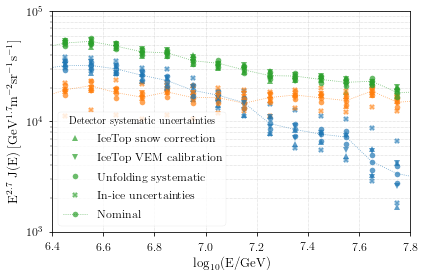

In [60]:
fig, ax = plt.subplots()

sys_color_dict = {'light': sns.color_palette('Blues', len(sys_names) + 1).as_hex(),
                  'heavy': sns.color_palette('Oranges', len(sys_names) + 1).as_hex(),
                  'total': sns.color_palette('Greens', len(sys_names) + 1).as_hex()}

for name, flux in unfolded_results.items():
#     marker = plot_marker(name)
    
    if 'snow_lambda' in name:
        marker = '^'
    elif 'dom_eff' in name:
        marker = 'X'
    elif 'vem_cal' in name:
        marker = 'v'
    else:
        marker = 'o'
    
    
    for idx, composition in enumerate(comp_list + ['total']):
        if composition == 'total':
            label_terms = name.split('_')
            stop_idx = -1 if len(label_terms) > 1 else None
            label = '_'.join(label_terms[:stop_idx])
            label = sys_labels[label]
        else:
            label = ''
        
        if 'down' in name:
            label = ''
            

        ax.plot(energybins.log_energy_midpoints, flux[composition],
                color=color_dict[composition],
                alpha=0.7, 
                ls=':' if 'nominal' in name else 'None',
                lw=0.8,
                marker=marker,
                label=label)

ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
ax.set_xlim(6.4, 7.8)
ax.set_ylim(1e3, 1e5)
ax.grid(lw=0.5, which='both')

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.legend(loc='upper center',
#           bbox_to_anchor=(0.5, 1.35),
#           ncol=3)
ax.legend(title='Detector systematic uncertainties')

outfile = os.path.join(comp.paths.figures_dir,
                       'systematics',
                       'detector-systematics-flux-comparison.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

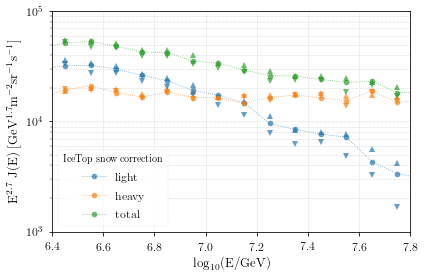

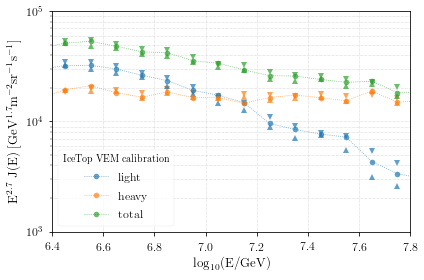

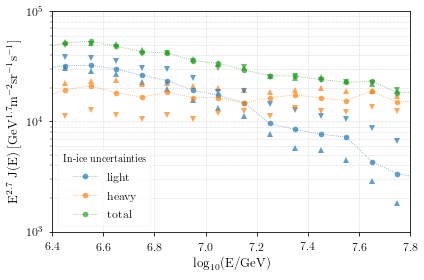

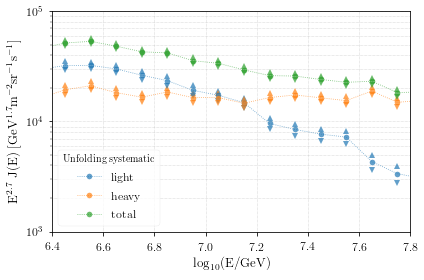

In [61]:
nominal_flux = unfolded_results['nominal']
for sys_type in sys_names:
    
    sys_results = {key:value for key, value in unfolded_results.items() if sys_type in key}
    fig, ax = plt.subplots()
    
    for sys_name, flux in sys_results.items():
        if 'up' in sys_name:
            marker = '^'
        else:
            marker = 'v'    
    
        for idx, composition in enumerate(comp_list + ['total']):
            ax.plot(energybins.log_energy_midpoints, flux[composition],
                    color=color_dict[composition],
                    alpha=0.7, 
                    ls='None',
                    marker=marker,
                   )
    for idx, composition in enumerate(comp_list + ['total']):
        # Plot nominal flux
        ax.plot(energybins.log_energy_midpoints, nominal_flux[composition],
                color=color_dict[composition],
                alpha=0.7, 
                ls=':',
                lw=0.8,
                marker='o',
                label=composition
               )

    ax.set_yscale('log', nonposy='clip')
    ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
    ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
    ax.set_xlim(6.4, 7.8)
    ax.set_ylim(1e3, 1e5)
    ax.grid(lw=0.5, which='both')

    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.legend(loc='upper center',
    #           bbox_to_anchor=(0.5, 1.35),
    #           ncol=3)
    title = sys_labels[sys_type]
    ax.legend(loc='lower left', title=title)

    outfile = os.path.join(comp.paths.figures_dir,
                           'systematics',
                           '{}-flux-comparison.png'.format(sys_type))
    comp.check_output_dir(outfile)
    plt.savefig(outfile)

    plt.show()

In [62]:
energybins.log_energy_midpoints

array([6.15, 6.25, 6.35, 6.45, 6.55, 6.65, 6.75, 6.85, 6.95, 7.05, 7.15,
       7.25, 7.35, 7.45, 7.55, 7.65, 7.75, 7.85, 7.95])

In [63]:
bin_width = energybins.log_energy_bin_width[0]
num_sys = len(sys_names)
step = bin_width / num_sys
step

0.02499999999999991

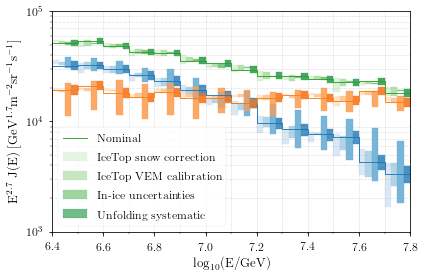

In [64]:
nominal_flux = unfolded_results['nominal']

sys_color_dict = {'light': sns.color_palette('Blues', len(sys_names) + 1).as_hex(),
                  'heavy': sns.color_palette('Oranges', len(sys_names) + 2).as_hex()[:-1],
                  'total': sns.color_palette('Greens', len(sys_names) + 1).as_hex()}


fig, ax = plt.subplots()
for sys_idx, sys_type in enumerate(sys_names):
    
    sys_results = {key:value for key, value in unfolded_results.items() if sys_type in key}
    
    for sys_name, flux in sys_results.items():
        if 'up' in sys_name:
            marker = '^'
        else:
            marker = 'v'    
    
        for idx, composition in enumerate(comp_list + ['total']):
            sys_fluxes = [value[composition] for value in sys_results.values()]
            sys_flux_max = np.max(sys_fluxes, axis=0)
            sys_flux_min = np.min(sys_fluxes, axis=0)
            x = energybins.log_energy_bins[:-1] + sys_idx * step
            
            if composition == 'total' and 'up' in sys_name:
                label = sys_labels[sys_type]
            else:
                label = ''
            
            for idx in range(len(x)):
                ax.fill_between([x[idx], x[idx]+step],
                                sys_flux_max[idx],
                                sys_flux_min[idx],
                                color=sys_color_dict[composition][sys_idx],
                                alpha=0.7,
                                label=label
                                )
#                 # Plot markers for different systematics
#                 ax.plot(x[idx] + step / 2, nominal_flux[composition][idx],
#                         color=color_dict[composition],
#                         alpha=1, 
#                         ls='None',
#                         marker=sys_markers[sys_type],
#                         label=label
#                        )
                if label:
                    label = ''

# Plot nominal flux
for idx, composition in enumerate(comp_list + ['total']):
    if composition == 'total':
        label = 'Nominal'
    else:
        label = ''
    comp.plot_steps(energybins.log_energy_bins, nominal_flux[composition],
                    color=color_dict[composition],
                    alpha=1, 
                    ls='-',
                    lw=0.9,
                    ax=ax,
                    label=label
                   )

ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')

major_ticks = energybins.log_energy_bins
ax.set_xticks(major_ticks, minor=True)

ax.set_xlim(6.4, 7.8)
ax.set_ylim(1e3, 1e5)

ax.grid(lw=0.5,
        which='minor')

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.legend(loc='upper center',
#           bbox_to_anchor=(0.5, 1.35),
#           ncol=3)
# title = sys_labels[sys_type]
ax.legend(loc='lower left',
#           title='Systematic uncertainties',
         )
outfile = os.path.join(comp.paths.figures_dir,
                       'systematics',
                       'systematics-flux-comparison-step.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

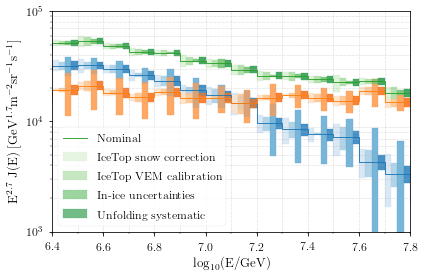

In [65]:
nominal_flux = unfolded_results['nominal']

sys_color_dict = {'light': sns.color_palette('Blues', len(sys_names) + 1).as_hex(),
                  'heavy': sns.color_palette('Oranges', len(sys_names) + 2).as_hex()[:-1],
                  'total': sns.color_palette('Greens', len(sys_names) + 1).as_hex()}


fig, ax = plt.subplots()
for sys_idx, sys_type in enumerate(sys_names):
    
    sys_results = {key:value for key, value in unfolded_results.items() if sys_type in key}
    
    for sys_name, flux in sys_results.items():
        if 'up' in sys_name:
            marker = '^'
        else:
            marker = 'v'    
    
        for idx, composition in enumerate(comp_list + ['total']):
            sys_fluxes = [value[composition] for value in sys_results.values()]
            sys_flux_max = np.max(sys_fluxes, axis=0)
            sys_flux_min = np.min(sys_fluxes, axis=0)
            
            sys_abs_deviation = np.max([np.abs(nominal_flux[composition] - sys_flux_max),
                                        np.abs(nominal_flux[composition] - sys_flux_min)],
                                       axis=0)
            
            x = energybins.log_energy_bins[:-1] + sys_idx * step
            
            if composition == 'total' and 'up' in sys_name:
                label = sys_labels[sys_type]
            else:
                label = ''
            
            for idx in range(len(x)):
                ax.fill_between([x[idx], x[idx]+step],
                                nominal_flux[composition][idx] + sys_abs_deviation[idx],
                                nominal_flux[composition][idx] - sys_abs_deviation[idx],
                                color=sys_color_dict[composition][sys_idx],
                                alpha=0.7,
                                label=label
                                )
                if label:
                    label = ''

# Plot nominal flux
for idx, composition in enumerate(comp_list + ['total']):
    if composition == 'total':
        label = 'Nominal'
    else:
        label = ''
    comp.plot_steps(energybins.log_energy_bins, nominal_flux[composition],
                    color=color_dict[composition],
                    alpha=1, 
                    ls='-',
                    lw=0.9,
                    ax=ax,
                    label=label
                   )

ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')

major_ticks = energybins.log_energy_bins
ax.set_xticks(major_ticks, minor=True)

ax.set_xlim(6.4, 7.8)
ax.set_ylim(1e3, 1e5)

ax.grid(lw=0.5,
        which='minor')

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.legend(loc='upper center',
#           bbox_to_anchor=(0.5, 1.35),
#           ncol=3)
# title = sys_labels[sys_type]
ax.legend(loc='lower left',
#           title='Systematic uncertainties',
         )
outfile = os.path.join(comp.paths.figures_dir,
                       'systematics',
                       'systematics-flux-comparison-step-max-deviation.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

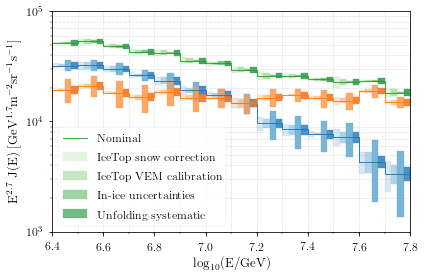

In [66]:
nominal_flux = unfolded_results['nominal']

sys_color_dict = {'light': sns.color_palette('Blues', len(sys_names) + 1).as_hex(),
                  'heavy': sns.color_palette('Oranges', len(sys_names) + 2).as_hex()[:-1],
                  'total': sns.color_palette('Greens', len(sys_names) + 1).as_hex()}


fig, ax = plt.subplots()
for sys_idx, sys_type in enumerate(sys_names):
    
    sys_results = {key:value for key, value in unfolded_results.items() if sys_type in key}
    
    for sys_name, flux in sys_results.items():
        if 'up' in sys_name:
            marker = '^'
        else:
            marker = 'v'    
    
        for idx, composition in enumerate(comp_list + ['total']):
            sys_fluxes = [value[composition] for value in sys_results.values()]
            sys_fluxes.append(nominal_flux[composition])
            sys_flux_max = np.max(sys_fluxes, axis=0)
            sys_flux_min = np.min(sys_fluxes, axis=0)
            
            sys_std_deviation = np.std(sys_fluxes, axis=0)
            
            x = energybins.log_energy_bins[:-1] + sys_idx * step
            
            if composition == 'total' and 'up' in sys_name:
                label = sys_labels[sys_type]
            else:
                label = ''
            
            for idx in range(len(x)):
                ax.fill_between([x[idx], x[idx]+step],
                                nominal_flux[composition][idx] + sys_std_deviation[idx],
                                nominal_flux[composition][idx] - sys_std_deviation[idx],
                                color=sys_color_dict[composition][sys_idx],
                                alpha=0.7,
                                label=label
                                )
                if label:
                    label = ''

# Plot nominal flux
for idx, composition in enumerate(comp_list + ['total']):
    if composition == 'total':
        label = 'Nominal'
    else:
        label = ''
    comp.plot_steps(energybins.log_energy_bins, nominal_flux[composition],
                    color=color_dict[composition],
                    alpha=1, 
                    ls='-',
                    lw=0.9,
                    ax=ax,
                    label=label
                   )

ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')

major_ticks = energybins.log_energy_bins
ax.set_xticks(major_ticks, minor=True)

ax.set_xlim(6.4, 7.8)
ax.set_ylim(1e3, 1e5)

ax.grid(lw=0.5,
        which='minor')

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.legend(loc='upper center',
#           bbox_to_anchor=(0.5, 1.35),
#           ncol=3)
# title = sys_labels[sys_type]
ax.legend(loc='lower left',
#           title='Systematic uncertainties',
         )
outfile = os.path.join(comp.paths.figures_dir,
                       'systematics',
                       'systematics-flux-comparison-step-std.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

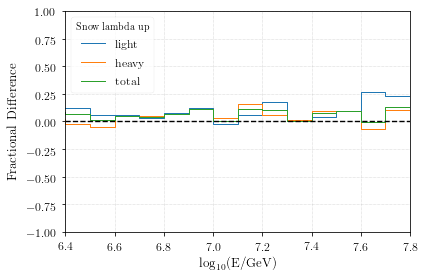

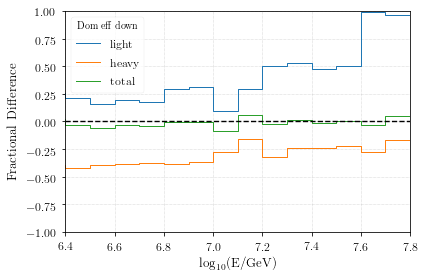

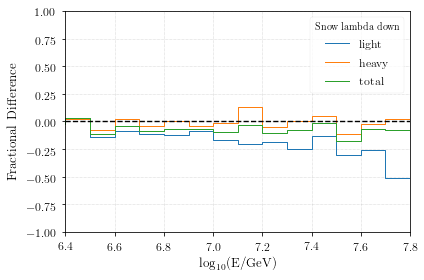

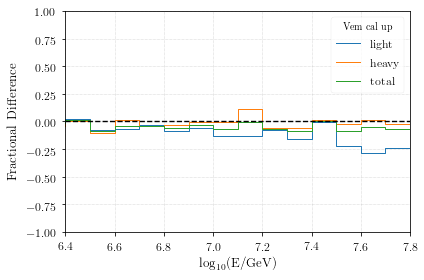

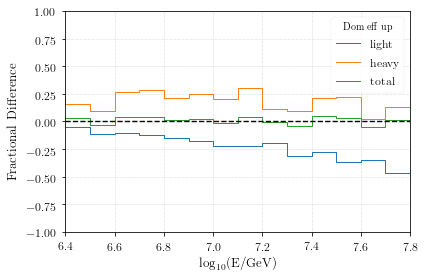

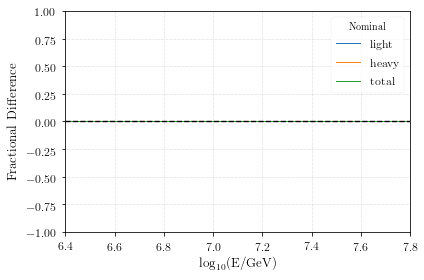

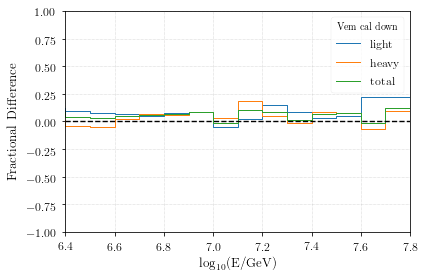

In [62]:
for name, flux in unfolded_results.items():
    
    fig, ax = plt.subplots()
    marker_dict = {'nominal': 'o', 'up': '^', 'down': 'v'}
    for idx, composition in enumerate(comp_list + ['total']):
        if composition == 'total':
            label = name.capitalize().replace('_', ' ')
        else:
            label = ''
        
        sys = (flux[composition] - nominal_flux[composition]) / nominal_flux[composition]
        comp.plot_steps(energybins.log_energy_bins,
                        sys,
                        color=color_dict[composition],
#                         ls='None',
#                         marker=marker,
                        label=composition)
    ax.axhline(0, ls='--', marker='None', color='k')
#     ax.set_yscale('log', nonposy='clip')
    ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
    ax.set_ylabel('Fractional Difference')
    ax.set_xlim(6.4, 7.8)
    ax.set_ylim(-1, 1)
    ax.grid(lw=0.5, which='both')

    ax.legend(title=label)

    # outfile = os.path.join(comp.paths.figures_dir,
    #                        'systematics',
    #                        'combined-flux-comparison.png')
    # comp.check_output_dir(outfile)
    # plt.savefig(outfile)

    plt.show()

In [149]:
s_up = set(i for i in b.data_vars if 'up' in i)
s_down = set(i for i in b.data_vars if 'down' in i)
s_up, s_down

({'snow_lambda_up', 'unfolding_sys_up', 'vem_cal_up'},
 {'snow_lambda_down', 'unfolding_sys_down', 'vem_cal_down'})

In [158]:
up_err = np.sqrt(np.sum([(b[i] - b['nominal'])**2 for i in s_up], axis=1))
down_err = np.sqrt(np.sum([(b[i] - b['nominal'])**2 for i in s_down], axis=1))
up_err

array([[ 8775.26544053,  3461.03492069,  5300.06282757,  5472.88050199,
         2258.96219814,  3328.14968529,  2166.51444741,  3752.2608054 ,
         5162.96835436,   696.21344379,  4053.25094015,  3349.99102214,
          233.65212858,  2399.69248542,  2641.6159454 ,  1662.07924328,
         2770.72295497,  2061.89856413,  4192.05162915],
       [12040.5394237 ,  6674.40802169,  6662.64281717,  6057.78694306,
         6328.06242819,  5628.00603922,  4702.11762272,  4183.88232319,
         3551.95540866,  3125.72956497,  2903.60107842,  2691.58825955,
         2950.14516703,  3055.55819309,  3094.96107495,  3312.19510485,
         3070.40711297,  3279.34755076,  3198.97193469],
       [ 8432.91246689,  6491.48164889,   991.63030865,   947.12377641,
         5997.11681946,  2898.79171702,  2079.84041475,  3462.60149626,
         1613.8361717 ,  3219.66302247,  2500.07452294,  2131.53693411,
         2730.0531372 ,   279.7065787 ,  2398.14998325,  1633.41786843,
         1429.55984991

In [174]:
np.asarray([up_err[0], down_err[0]])

array([[8775.26544053, 3461.03492069, 5300.06282757, 5472.88050199,
        2258.96219814, 3328.14968529, 2166.51444741, 3752.2608054 ,
        5162.96835436,  696.21344379, 4053.25094015, 3349.99102214,
         233.65212858, 2399.69248542, 2641.6159454 , 1662.07924328,
        2770.72295497, 2061.89856413, 4192.05162915],
       [9399.20359289, 4686.66675852, 5453.37912046, 3920.95954915,
        3265.16409171, 3270.96831663, 3180.95856637, 3579.6456476 ,
        3830.84634192, 1071.87954847, 4043.84126653, 2765.27966966,
         890.96412844, 2085.63185599, 2028.4573015 , 1537.58915756,
        2646.70017801, 1161.74236437, 3154.58700851]])

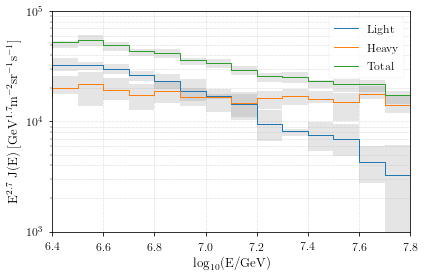

In [221]:
fig, ax = plt.subplots()
colors = ['k', 'red']
names = ['VEM cal.', 'Snow $\mathrm{\lambda}$']
marker_dict = {'nominal': 'o', 'up': '^', 'down': 'v'}
for idx, composition in enumerate(comp_list + ['total']):
    if composition == 'total':
        label = name.capitalize().replace('_', ' ')
    else:
        label = ''

    comp.plot_steps(energybins.log_energy_bins,
                    b['nominal'][idx],
                    yerr=[down_err[idx], up_err[idx]],
                    color=color_dict[composition],
                    fillcolor='gray',
                    ls='-',
                    label=composition.capitalize(),
                    ax=ax)

ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
ax.set_xlim(6.4, 7.8)
ax.set_ylim(1e3, 1e5)
ax.grid(lw=0.5, which='both')
ax.legend()

outfile = os.path.join(comp.paths.figures_dir,
                       'systematics',
                       'net-systematics-flux.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

In [189]:
s = set([i.replace('_up', '').replace('_down', '') for i in b.data_vars if i != 'nominal'])
s

{'snow_lambda', 'unfolding_sys', 'vem_cal'}

In [216]:
len(s)

3

In [220]:
dw = 0.1 / len(s)
dw / 2

0.016666666666666666

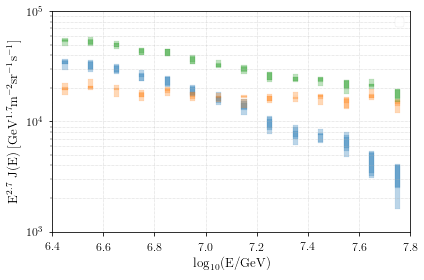

In [215]:
fig, ax = plt.subplots()
colors = ['k', 'red']
names = ['VEM cal.', 'Snow $\mathrm{\lambda}$']
marker_dict = {'nominal': 'o', 'up': '^', 'down': 'v'}
for name in s:
    up_flux = b[name+'_up']
    down_flux = b[name+'_down']
    for idx, composition in enumerate(comp_list + ['total']):
        
        if composition == 'total':
            label = name.capitalize().replace('_', ' ')
        else:
            label = ''
        for j, i in enumerate(energybins.log_energy_midpoints):
            x = [i - 0.01, i + 0.01]
            ax.fill_between(x,
                            [up_flux[idx].values[j]]*2,
                            [down_flux[idx].values[j]]*2,
                            color=color_dict[composition],
                            alpha=0.3)
#                             label=label)

ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
ax.set_xlim(6.4, 7.8)
ax.set_ylim(1e3, 1e5)
ax.grid(lw=0.5, which='both')
ax.legend()

# outfile = os.path.join(comp.paths.figures_dir,
#                        'systematics',
#                        'combined-flux-comparison.png')
# comp.check_output_dir(outfile)
# plt.savefig(outfile)

plt.show()

In [208]:
[up_flux[idx].values[i]]*2

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

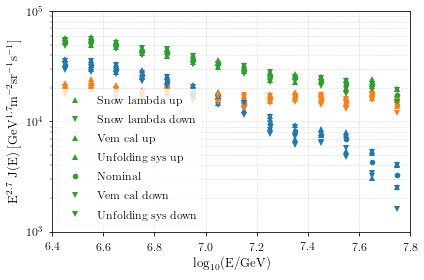

In [132]:
fig, ax = plt.subplots()
colors = ['k', 'red']
names = ['VEM cal.', 'Snow $\mathrm{\lambda}$']
marker_dict = {'nominal': 'o', 'up': '^', 'down': 'v'}
for name in b.data_vars:
    flux = b[name]
    marker = plot_marker(name)
    for idx, composition in enumerate(comp_list + ['total']):
        if composition == 'total':
            label = name.capitalize().replace('_', ' ')
        else:
            label = ''

        ax.plot(energybins.log_energy_midpoints, flux[idx],
                color=color_dict[composition],
                ls='None',
                marker=marker,
                label=label)

ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
ax.set_xlim(6.4, 7.8)
ax.set_ylim(1e3, 1e5)
ax.grid(lw=0.5, which='both')
ax.legend()

# outfile = os.path.join(comp.paths.figures_dir,
#                        'systematics',
#                        'combined-flux-comparison.png')
# comp.check_output_dir(outfile)
# plt.savefig(outfile)

plt.show()

down
nominal
up
down
nominal
up


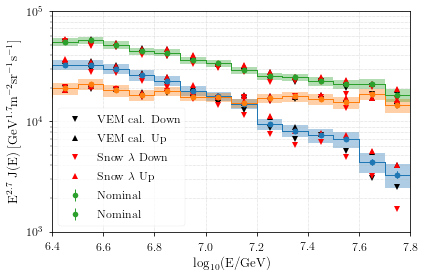

In [93]:
fig, ax = plt.subplots()
systematics_files = ['vem_calibration_systematic_flux.pkl', 'snow_lambda_systematic_flux.pkl']
colors = ['k', 'red']
names = ['VEM cal.', 'Snow $\mathrm{\lambda}$']
marker_dict = {'nominal': 'o', 'up': '^', 'down': 'v'}
for f, sys_color, sys_name in zip(systematics_files, colors, names):
    unfolded_results = joblib.load(f)
    linestyles = iter(['-', ':', '-.', '--'])
    markers = iter(['.', '^', 'X'])
    for shift_type, unfolded_systematic in unfolded_results.items():
        marker = marker_dict[shift_type]
        for composition in comp_list + ['total']:
            if composition == 'total':
                label = shift_type.capitalize() if shift_type == 'nominal' else '{} {}'.format(sys_name, shift_type.capitalize())
            else:
                label = ''
            
            if shift_type == 'nominal':
                comp.plot_steps(energybins.log_energy_bins, unfolded_systematic[composition].flux,
                                yerr=unfolded_systematic[composition].flux_sys_err,
                                color=color_dict[composition],
                                ls='-',
                                ax=ax)

                ax.errorbar(energybins.log_energy_midpoints, unfolded_systematic[composition].flux,
                            yerr=unfolded_systematic[composition].flux_stat_err,
                            color=color_dict[composition],
                            ls='None',
                            marker=marker,
                            capsize=20,
                            elinewidth=1,
                            label=label)
            else:
                ax.plot(energybins.log_energy_midpoints, unfolded_systematic[composition].flux,
                        color=sys_color,
                        ls='None',
                        marker=marker,
                        label=label)

ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
ax.set_xlim(6.4, 7.8)
ax.set_ylim(1e3, 1e5)
ax.grid(lw=0.5, which='both')
ax.legend()

outfile = os.path.join(comp.paths.figures_dir,
                       'systematics',
                       'combined-flux-comparison.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

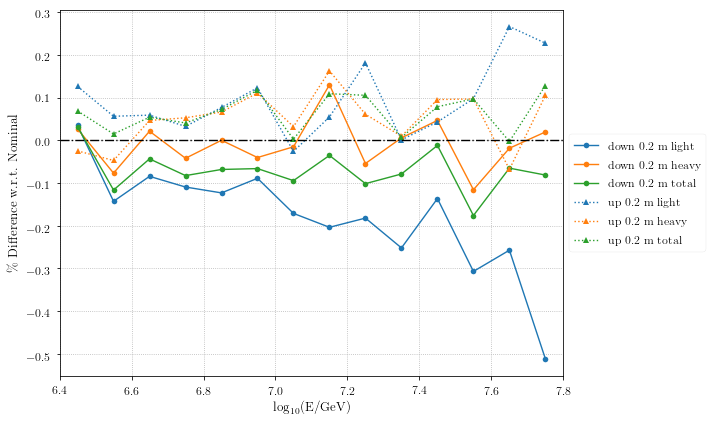

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
# unfolded_counts = {}
linestyles = iter(['-', ':', '-.', '--'])
markers = iter(['o', '^', 'X'])
vem_systematic = []
for shift_type in ['down', 'up']:
    shift_systematic = {}
    marker = next(markers)
    ls = next(linestyles)
    for composition in comp_list + ['total']:
        nominal = unfolded_counts['nominal'][composition]
        deviation = (unfolded_counts[shift_type][composition] - nominal) / nominal
        energy_mask = np.logical_and(energybins.log_energy_midpoints < 7.8,
                                     energybins.log_energy_midpoints > 6.4)
        ax.plot(energybins.log_energy_midpoints[energy_mask], deviation[energy_mask],
                color=color_dict[composition],
                marker=marker,
                ls=ls,
                label='{} 0.2 m {}'.format(shift_type, composition))
        shift_systematic[composition] = np.mean(np.abs(deviation[energy_mask]))
        
    vem_systematic.append(shift_systematic)

ax.axhline(0.0, marker='None', ls='-.', color='k')
ax.set(xlabel='$\mathrm{\log_{10}(E/GeV)}$',
       xlim=(6.4, 7.8),
       ylabel='\% Difference w.r.t. Nominal')
ax.grid()
# ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

outfile = os.path.join(comp.paths.figures_dir,
                       'systematics',
                       'snow-lambda-counts-deviation.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

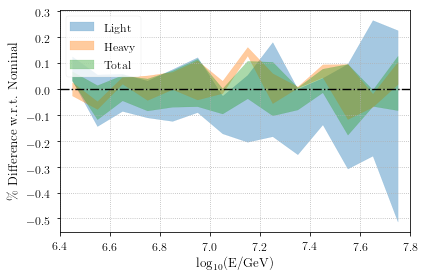

In [37]:
fig, ax = plt.subplots()
# fig, ax = plt.subplots(figsize=(10, 6))
for composition in comp_list + ['total']:
    nominal = unfolded_counts['nominal'][composition]
    
    max_counts = np.stack((unfolded_counts['down'][composition], unfolded_counts['up'][composition])).max(axis=0)
    min_counts = np.stack((unfolded_counts['down'][composition], unfolded_counts['up'][composition])).min(axis=0)
    
    deviation_upper = (max_counts - nominal) / nominal
    deviation_lower = (min_counts - nominal) / nominal
    energy_mask = np.logical_and(energybins.log_energy_midpoints < 7.8,
                                 energybins.log_energy_midpoints > 6.4)
    ax.fill_between(energybins.log_energy_midpoints[energy_mask],
                    deviation_upper[energy_mask],
                    deviation_lower[energy_mask],
                    color=color_dict[composition],
                    alpha=0.4,
                    label=composition.capitalize())

ax.axhline(0.0, marker='None', ls='-.', color='k')
ax.set(xlabel='$\mathrm{\log_{10}(E/GeV)}$',
       xlim=(6.4, 7.8),
       ylabel='\% Difference w.r.t. Nominal')
ax.grid()
ax.legend(loc='upper left')
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

outfile = os.path.join(comp.paths.figures_dir,
                       'systematics',
                       'snow-lambda-counts-deviation-bands.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

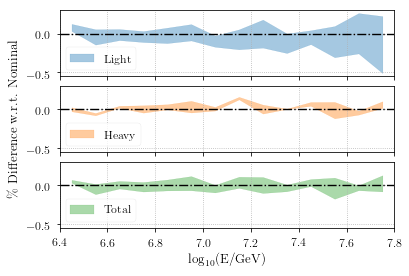

In [38]:
fig, axes = plt.subplots(ncols=1, nrows=3,
                         sharey=True, sharex=True,
                         gridspec_kw={'hspace':0.15})

for idx, (composition, ax) in enumerate(zip(comp_list + ['total'], axes)):
   
    nominal = unfolded_counts['nominal'][composition]
    
    max_counts = np.stack((unfolded_counts['down'][composition], unfolded_counts['up'][composition])).max(axis=0)
    min_counts = np.stack((unfolded_counts['down'][composition], unfolded_counts['up'][composition])).min(axis=0)
    
    deviation_upper = (max_counts - nominal) / nominal
    deviation_lower = (min_counts - nominal) / nominal
    energy_mask = np.logical_and(energybins.log_energy_midpoints < 7.8,
                                 energybins.log_energy_midpoints > 6.4)
    ax.fill_between(energybins.log_energy_midpoints[energy_mask],
                    deviation_upper[energy_mask],
                    deviation_lower[energy_mask],
                    color=color_dict[composition],
                    alpha=0.4,
                    label=composition.capitalize())

    ax.axhline(0.0, marker='None', ls='-.', color='k')
    ax.set_xlim(6.4, 7.8)
    if idx == 1:
        ax.set_ylabel('\% Difference w.r.t. Nominal')
    ax.grid()
    ax.legend(loc='lower left')
    
ax.set(xlabel='$\mathrm{\log_{10}(E/GeV)}$')
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

outfile = os.path.join(comp.paths.figures_dir,
                       'systematics',
                       'snow-lambda-counts-deviation-bands-2.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)
plt.tight_layout()
plt.show()

In [39]:
vem_systematic = pd.DataFrame.from_records(vem_systematic, index=['down', 'up'])

In [40]:
vem_systematic

,heavy,light,total
down,0.043739,0.185994,0.07525
up,0.069823,0.097823,0.06406


In [28]:
# fig, ax = plt.subplots()
# im = ax.imshow(response, origin='lower', cmap='viridis')
# ax.plot([0, response.shape[0] - 1], [0, response.shape[1] - 1], marker='None', ls=':', color='white')
# comp.plotting.colorbar(im, label='Normalized response matrix')

# ax.set_xlabel('True bins')
# ax.set_ylabel('Reconstructed bins')

# plt.show()

In [23]:
# Run unfolding for each of the priors
names = ['uniform', 'H3a', 'H4a', 'simple_power_law']
# names = ['Jeffreys', 'H3a', 'H4a', 'Polygonato']
unfolding_results = {}
for prior_name in names:
    prior = None if prior_name == 'uniform' else df_priors['{}_prior'.format(prior_name)]
    # priors = 'Jeffreys' if prior_name == 'Jeffreys' else df['{}_prior'.format(prior_name)]
    df_unfolding_iter = pyunfold.iterative_unfold(data=counts_pyunfold,
                                                  data_err=counts_err_pyunfold,
                                                  response=response,
                                                  response_err=response_err,
                                                  efficiencies=efficiencies,
                                                  efficiencies_err=efficiencies_err,
                                                  ts='ks',
                                                  ts_stopping=0.005,
                                                  prior=prior,
                                                  return_iterations=True)
#                                                   callbacks=[pyunfold.callbacks.SplineRegularizer(degree=1, smooth=256)])
    unfolding_results[prior_name] = df_unfolding_iter

In [24]:
names

['uniform', 'H3a', 'H4a', 'simple_power_law']

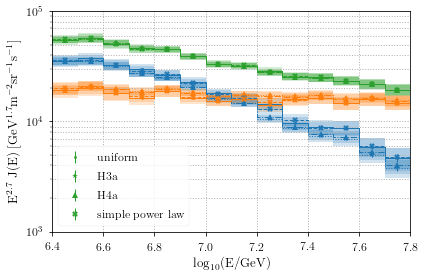

In [25]:
fig, ax = plt.subplots()
# fig, ax = plt.subplots(figsize=(10, 5))
linestyles = ['-', ':', '-.', '--']
markers = ['.', '*', '^', 'X']
for prior_name, ls, marker in zip(names, linestyles, markers):
#     if prior_name != 'H4a':
#         continue
    counts, counts_sys_err, counts_stat_err = comp.unfolded_counts_dist(unfolding_results[prior_name],
                                                                        num_groups=num_groups)
    for composition in comp_list + ['total']:
#         print(composition)
#         print(counts[composition])
        flux, flux_sys_err = counts_to_flux(counts=counts[composition],
                                            counts_err=counts_sys_err[composition],
                                            composition=composition)
        flux, flux_stat_err = counts_to_flux(counts=counts[composition],
                                             counts_err=counts_stat_err[composition],
                                             composition=composition)
        comp.plot_steps(energybins.log_energy_bins, flux,
                        yerr=flux_sys_err,
                        color=color_dict[composition],
                        ls=ls,
                        ax=ax)
#         label = '{} ({})'.format(composition, prior_name.replace('_', '-'))
        label = prior_name.replace('_', ' ') if composition == 'total' else ''
        ax.errorbar(energybins.log_energy_midpoints, flux,
                    yerr=flux_stat_err,
                    color=color_dict[composition],
                    ls='None',
                    marker=marker,
                    capsize=20,
                    elinewidth=1,
                    label=label)
ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
ax.set_xlim(6.4, 7.8)
ax.set_ylim(1e3, 1e5)
ax.grid(lw=1, which='both')
ax.legend()
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.legend(loc='upper center',
#           bbox_to_anchor=(0.5, 1.75),
#           ncol=2,
#           fancybox=True)

# outfile = os.path.join(comp.paths.figures_dir, 'skymaps', 'allsky.png')
# comp.check_output_dir(outfile)
# plt.savefig(outfile)

plt.show()

In [220]:
unfolding_results[prior_name]

,num_iterations,stat_err,sys_err,ts_iter,ts_stopping,unfolded
0,1,"[103070.02504396967, 102144.86379256786, 50670...","[15749287.516949983, 15916022.452854631, 63263...",0.092134,0.005,"[191757396.1416671, 185164877.99562967, 100489..."
1,2,"[131953.06978832203, 129540.18108453172, 63206...","[20462526.446218558, 20765857.73598618, 772244...",0.013259,0.005,"[194439030.48473287, 183098573.05224302, 97407..."
2,3,"[156768.8273093421, 154851.65411568832, 76436....","[24771671.80102233, 25258328.6961266, 9280394....",0.006603,0.005,"[199315688.28344995, 184217275.63812009, 95749..."
3,4,"[179558.32058617944, 178243.33187288075, 88589...","[28715669.559097447, 29414788.434875157, 10789...",0.006247,0.005,"[203645760.02327502, 185650774.9339217, 942914..."
4,5,"[200461.48714098573, 199795.5892395803, 99408....","[32313868.88569669, 33238876.805621095, 121820...",0.005381,0.005,"[207218369.0219479, 187062412.3038028, 9288674..."
5,6,"[219513.50583395315, 219594.3790580178, 108934...","[35591637.47533877, 36746004.07863727, 1344948...",0.004610,0.005,"[210131297.34194955, 188430133.6614856, 915163..."


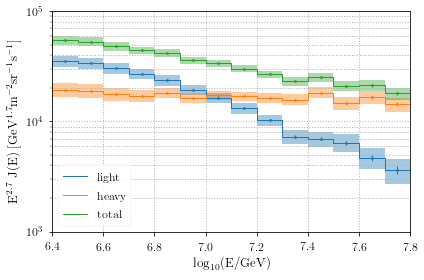

In [224]:
fig, ax = plt.subplots()
# fig, ax = plt.subplots(figsize=(10, 5))

prior_name = 'H4a'
marker = '.'
ls = '-'
counts, counts_sys_err, counts_stat_err = comp.unfolded_counts_dist(unfolding_results[prior_name],
                                                                    num_groups=num_groups)
for composition in comp_list + ['total']:
    flux, flux_sys_err = counts_to_flux(counts=counts[composition],
                                        counts_err=counts_sys_err[composition],
                                        composition=composition)
    flux, flux_stat_err = counts_to_flux(counts=counts[composition],
                                         counts_err=counts_stat_err[composition],
                                         composition=composition)
    comp.plot_steps(energybins.log_energy_bins, flux,
                    yerr=flux_sys_err,
                    color=color_dict[composition],
                    fillalpha=0.4,
                    ls=ls,
                    label=composition,
                    ax=ax)
    ax.errorbar(energybins.log_energy_midpoints, flux,
                yerr=flux_stat_err,
                color=color_dict[composition],
                ls='None',
                marker=marker,
                capsize=20,
                elinewidth=1)

ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
ax.set_xlim(6.4, 7.8)
ax.set_ylim(1e3, 1e5)
ax.grid(lw=1, which='both')

ax.legend()
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.legend(loc='upper center',
#           bbox_to_anchor=(0.5, 1.75),
#           ncol=2,
#           fancybox=True)

outfile = os.path.join(comp.paths.figures_dir, 'skymaps', 'allsky.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()